In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from bioservices import BioMart
import io
from bioservices import BioMart

# Human and Chimp, GSE151397

In [41]:
df_counts_human = pd.read_csv('data/GSE151397_OrthologousExonRawGeneCounts_Human.tsv', sep='\t')
df_counts_chimp = pd.read_csv('data/GSE151397_OrthologousExonRawGeneCounts_Chimpanzee.tsv', sep='\t')

df_counts_human = df_counts_human.drop(columns=['Chr', 'Start', 'End', 'Strand', 'Length'])
df_counts_chimp = df_counts_chimp.drop(columns=['Chr', 'Start', 'End', 'Strand', 'Length'])

df_counts_human.columns = ['gene_id'] + [f'human{i}' for i in range(1, len(df_counts_human.columns))]
df_counts_chimp.columns = ['gene_id'] + [f'chimp{i}' for i in range(1, len(df_counts_chimp.columns))]
sample_columns = list(df_counts_human.columns[1:]) + list(df_counts_chimp.columns[1:])

df_counts = pd.merge(df_counts_human, df_counts_chimp, on='gene_id', how='inner')

In [42]:
len(df_counts)

44125

In [43]:
mart = BioMart(host="www.ensembl.org")

mart.database = "ENSEMBL_MART_ENSEMBL"
mart.dataset = "hsapiens_gene_ensembl"

query = """<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE Query>
<Query virtualSchemaName="default" formatter="TSV" header="1" uniqueRows="1" count="" datasetConfigVersion="0.6">
    <Dataset name="hsapiens_gene_ensembl" interface="default">
        <Attribute name="ensembl_gene_id" />
        <Attribute name="external_gene_name" />
        <Attribute name="gene_biotype" />
    </Dataset>
</Query>
"""

response = mart.query(query)

gene_annotations = pd.read_csv(io.StringIO(response), sep="\t")  
gene_annotations.columns = ['gene_id', 'gene_symbol', 'gene_biotype']

protein_coding_genes = gene_annotations[gene_annotations['gene_biotype'] == 'protein_coding']

df_counts = pd.merge(df_counts, protein_coding_genes[['gene_id', 'gene_symbol']], on='gene_id', how='inner')
df_counts = df_counts.dropna()

In [44]:
len(df_counts)

17342

In [45]:
df_counts['mean'] = (df_counts.filter(like='human').sum(axis=1) / (len(df_counts_human.columns) - 1) + df_counts.filter(like='chimp').sum(axis=1) / (len(df_counts_chimp.columns) - 1)) / 2
df_counts.head()

,gene_id,human1,human2,human3,human4,human5,human6,human7,human8,human9,...,chimp32,chimp33,chimp34,chimp35,chimp36,chimp37,chimp38,chimp39,gene_symbol,mean
0,ENSG00000188976,31,20,25,25,52,2,5,5,13,...,43,74,32,74,41,75,47,25,NOC2L,35.602564
1,ENSG00000188157,12,9,16,14,49,5,1,7,4,...,1,3,21,26,6,16,17,6,AGRN,17.190738
2,ENSG00000237330,0,0,0,0,0,0,0,0,0,...,1,0,2,1,1,5,2,0,RNF223,0.610152
3,ENSG00000186891,2,4,2,2,5,27,0,6,5,...,19,13,12,173,10,15,28,6,TNFRSF18,33.481162
4,ENSG00000186827,13,121,38,123,114,1443,42,106,32,...,356,352,195,216,328,510,406,134,TNFRSF4,266.704082


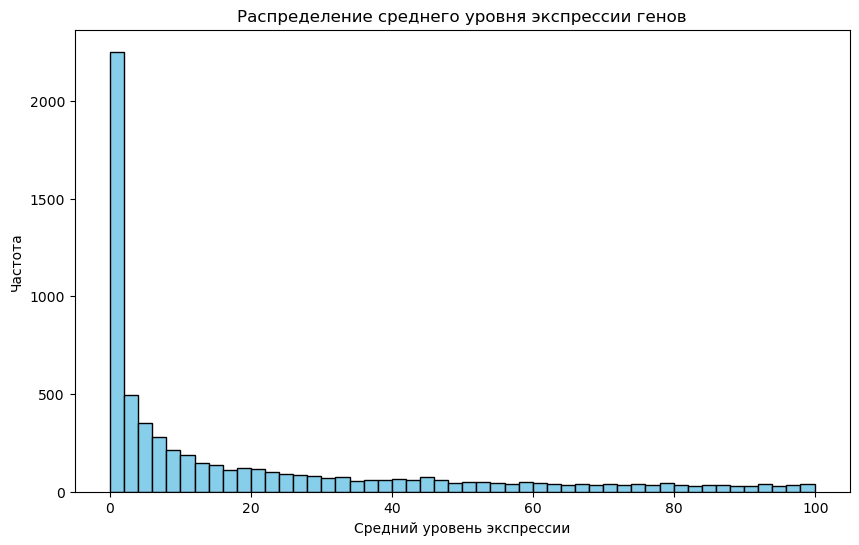

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(df_counts[(df_counts['mean'] < 100)]['mean'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Средний уровень экспрессии')
plt.ylabel('Частота')
plt.title('Распределение среднего уровня экспрессии генов')
plt.show()

In [47]:
df_counts = df_counts[df_counts['mean'] > 5]

In [48]:
len(df_counts)

14398

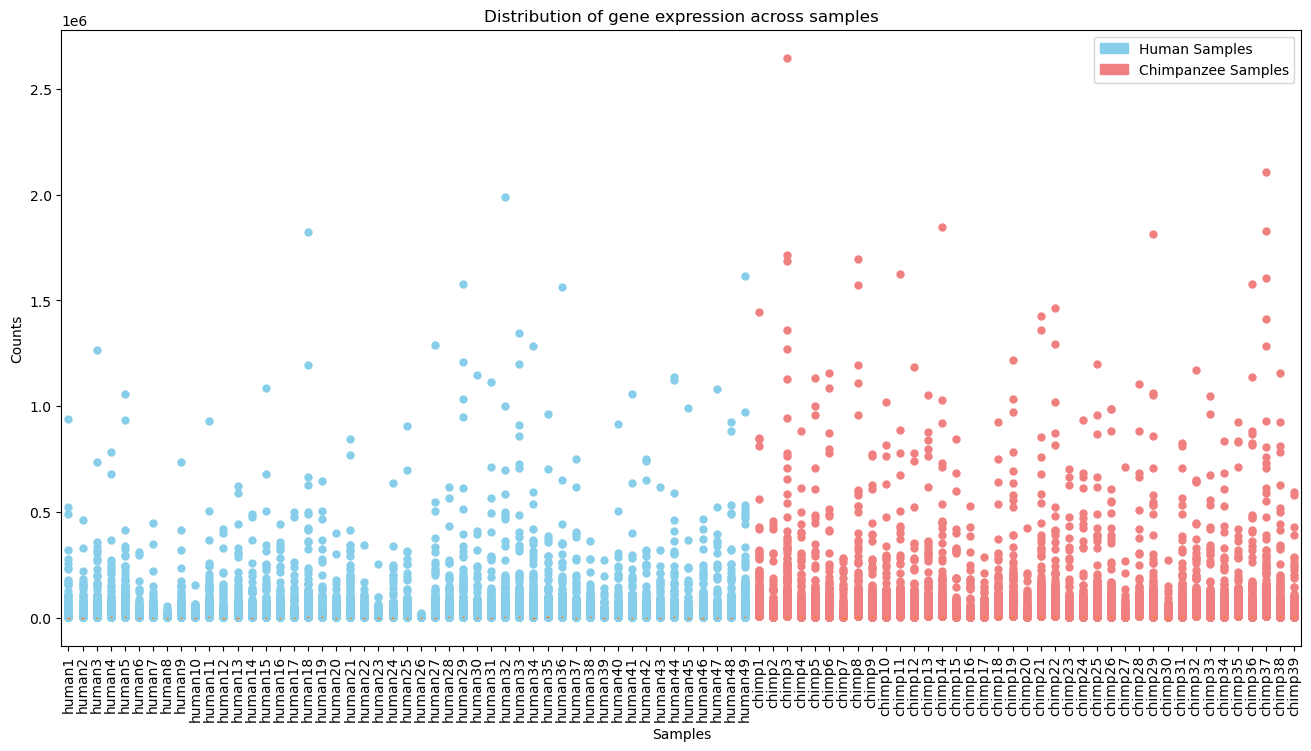

In [49]:
num_human_samples = len(df_counts_human.columns) - 1
num_chimp_samples = len(df_counts_chimp.columns) - 1

colors = ['skyblue'] * num_human_samples + ['lightcoral'] * num_chimp_samples

sample_columns = df_counts_human.columns[1:].tolist() + df_counts_chimp.columns[1:].tolist()

plt.figure(figsize=(16, 8))
for i, (column, color) in enumerate(zip(sample_columns, colors), start=1):
    plt.boxplot(df_counts[column].dropna(), positions=[i], patch_artist=True,
                boxprops=dict(facecolor=color, color=color),
                whiskerprops=dict(color=color),
                capprops=dict(color=color),
                flierprops=dict(markerfacecolor=color, markeredgecolor=color, markersize=5))

plt.xticks(ticks=range(1, len(sample_columns) + 1), labels=sample_columns, rotation=90)
plt.xlabel("Samples")
plt.ylabel("Counts")
plt.title("Distribution of gene expression across samples")

human_patch = mpatches.Patch(color='skyblue', label='Human Samples')
chimp_patch = mpatches.Patch(color='lightcoral', label='Chimpanzee Samples')
plt.legend(handles=[human_patch, chimp_patch], loc="upper right")

plt.show()


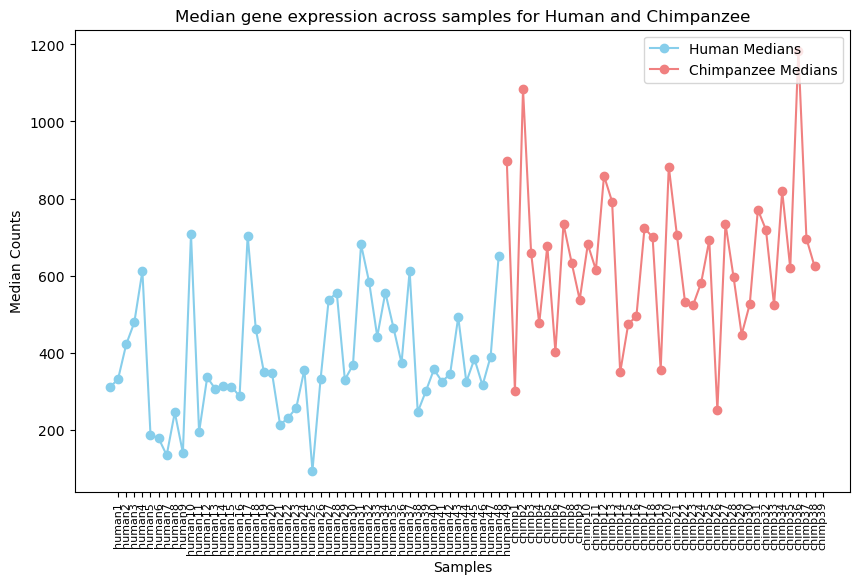

In [50]:
human_medians = df_counts[df_counts_human.columns[1:]].median()
chimp_medians = df_counts[df_counts_chimp.columns[1:]].median()

plt.figure(figsize=(10, 6))

plt.plot(human_medians.index, human_medians.values, marker='o', color='skyblue', label='Human Medians')
plt.plot(chimp_medians.index, chimp_medians.values, marker='o', color='lightcoral', label='Chimpanzee Medians')

plt.xticks(ticks=range(1, len(sample_columns) + 1), labels=sample_columns, rotation=90, fontsize=8)
plt.xlabel("Samples")
plt.ylabel("Median Counts")
plt.title("Median gene expression across samples for Human and Chimpanzee")
plt.legend(loc="upper right")

plt.show()

In [51]:
df_counts = df_counts[['gene_symbol'] + sample_columns]
df_counts = df_counts.groupby('gene_symbol', as_index=False).max()
df_counts.iloc[:, 1:] = df_counts.iloc[:, 1:].astype(int)
df_counts.to_csv('data/counts_postprocessing.tsv', index=False, sep='\t')

# Chimp and macaca, GSE112356

In [66]:
df_counts = pd.read_csv('data/GSE112356_RNA_counts.txt', sep='\t')

In [67]:
df_counts.head()

,gene_id,C1H,C1K,C1Li,C1Lu,C2H,C2K,C2Li,C2Lu,C3H,...,R2Li,R2Lu,R3H,R3K,R3Li,R3Lu,R4H,R4K,R4Li,R4Lu
0,ENSG00000000003,645,3217,6687,1436,539,2178,5590,1102,769,...,7517,2005,500,4005,5547,2088,519,4719,6289,1978
1,ENSG00000000005,145,12,8,3,33,13,5,11,10,...,8,1,1,1,2,3,3,8,1,0
2,ENSG00000000419,1559,1337,1336,1433,1074,1107,1203,1712,1303,...,995,1173,996,1151,1197,1479,752,1283,1330,1585
3,ENSG00000000457,641,1334,1304,1009,597,1262,1998,1476,626,...,859,1531,427,983,773,1710,398,1221,1202,1367
4,ENSG00000000460,77,131,92,159,66,126,107,189,76,...,53,209,71,102,50,284,37,98,87,346


In [68]:
df_counts.columns

Index(['gene_id', 'C1H', 'C1K', 'C1Li', 'C1Lu', 'C2H', 'C2K', 'C2Li', 'C2Lu',
       'C3H', 'C3K', 'C3Li', 'C3Lu', 'C4H', 'C4K', 'C4Li', 'C4Lu', 'H1H',
       'H1K', 'H1Li', 'H1Lu', 'H2H', 'H2K', 'H2Li', 'H2Lu', 'H3H', 'H3K',
       'H3Li', 'H3Lu', 'H4H', 'H4K', 'H4Li', 'H4Lu', 'R1H', 'R1K', 'R1Li',
       'R1Lu', 'R2H', 'R2K', 'R2Li', 'R2Lu', 'R3H', 'R3K', 'R3Li', 'R3Lu',
       'R4H', 'R4K', 'R4Li', 'R4Lu'],
      dtype='object')

In [69]:
df_counts = df_counts.rename(columns={'C1H': 'chimp1', 'C2H': 'chimp2', 'C3H': 'chimp3', 'C4H': 'chimp4',
                                      'R1H': 'macaca1', 'R2H': 'macaca2', 'R3H': 'macaca3', 'R4H': 'macaca4'})

In [70]:
df_counts = df_counts[['gene_id'] + [f'chimp{i}' for i in range(1, 5)] + [f'macaca{i}' for i in range(1, 5)]]
len(df_counts)

30030

In [71]:
mart = BioMart(host="www.ensembl.org")

mart.database = "ENSEMBL_MART_ENSEMBL"
mart.dataset = "hsapiens_gene_ensembl"

query = """<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE Query>
<Query virtualSchemaName="default" formatter="TSV" header="1" uniqueRows="1" count="" datasetConfigVersion="0.6">
    <Dataset name="hsapiens_gene_ensembl" interface="default">
        <Attribute name="ensembl_gene_id" />
        <Attribute name="external_gene_name" />
        <Attribute name="gene_biotype" />
    </Dataset>
</Query>
"""

response = mart.query(query)

gene_annotations = pd.read_csv(io.StringIO(response), sep="\t")  
gene_annotations.columns = ['gene_id', 'gene_symbol', 'gene_biotype']

protein_coding_genes = gene_annotations[gene_annotations['gene_biotype'] == 'protein_coding']

df_counts = pd.merge(df_counts, protein_coding_genes[['gene_id', 'gene_symbol']], on='gene_id', how='inner')
df_counts = df_counts.dropna()

In [72]:
len(df_counts)

16571

In [73]:
df_counts['mean'] = (df_counts.filter(like='human').sum(axis=1) / (len(df_counts_human.columns) - 1) + df_counts.filter(like='chimp').sum(axis=1) / (len(df_counts_chimp.columns) - 1)) / 2
df_counts.head()

,gene_id,chimp1,chimp2,chimp3,chimp4,macaca1,macaca2,macaca3,macaca4,gene_symbol,mean
0,ENSG00000000003,645,539,769,475,270,399,500,519,TSPAN6,31.128205
1,ENSG00000000005,145,33,10,363,0,2,1,3,TNMD,7.064103
2,ENSG00000000419,1559,1074,1303,1391,582,635,996,752,DPM1,68.294872
3,ENSG00000000457,641,597,626,631,257,321,427,398,SCYL3,31.987179
4,ENSG00000000460,77,66,76,69,32,43,71,37,FIRRM,3.692308


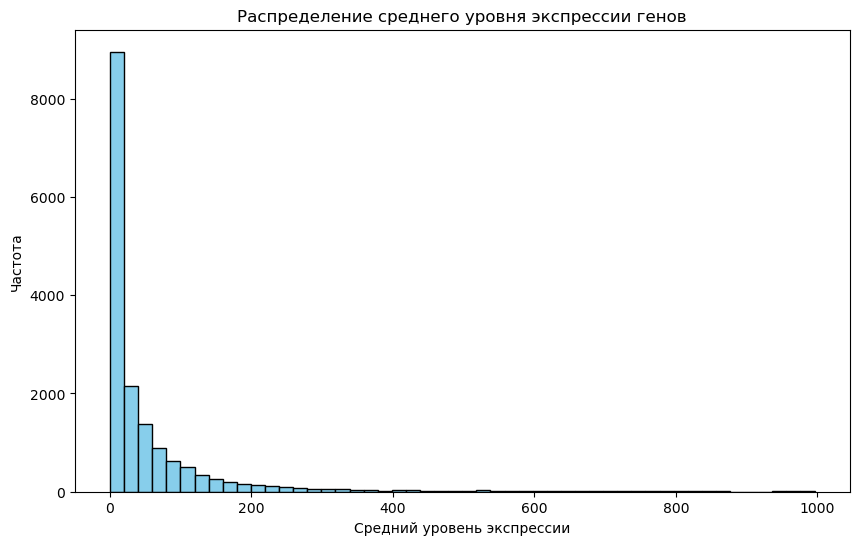

In [76]:
plt.figure(figsize=(10, 6))
plt.hist(df_counts[(df_counts['mean'] < 1000)]['mean'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Средний уровень экспрессии')
plt.ylabel('Частота')
plt.title('Распределение среднего уровня экспрессии генов')
plt.show()

In [78]:
df_counts = df_counts[df_counts['mean'] > 5]
len(df_counts)

10640

In [79]:
df_counts.head()

,gene_id,chimp1,chimp2,chimp3,chimp4,macaca1,macaca2,macaca3,macaca4,gene_symbol,mean
0,ENSG00000000003,645,539,769,475,270,399,500,519,TSPAN6,31.128205
1,ENSG00000000005,145,33,10,363,0,2,1,3,TNMD,7.064103
2,ENSG00000000419,1559,1074,1303,1391,582,635,996,752,DPM1,68.294872
3,ENSG00000000457,641,597,626,631,257,321,427,398,SCYL3,31.987179
5,ENSG00000000938,1329,121,796,314,47,81,165,97,FGR,32.820513


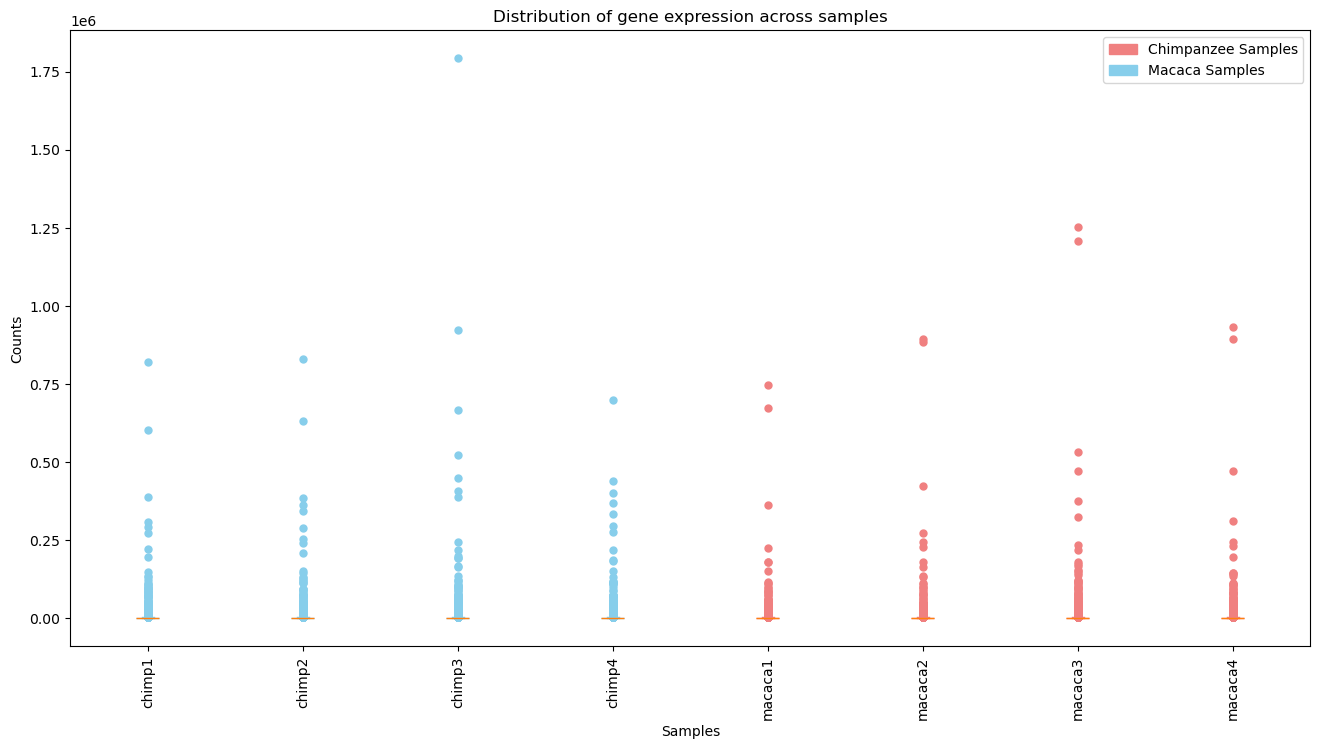

In [96]:
num_chimp_samples = 4
num_macaca_samples = 4

colors = ['skyblue'] * num_macaca_samples + ['lightcoral'] * num_chimp_samples

sample_columns = df_counts.columns[1:-2].tolist()

plt.figure(figsize=(16, 8))
for i, (column, color) in enumerate(zip(sample_columns, colors), start=1):
    plt.boxplot(df_counts[column].dropna(), positions=[i], patch_artist=True,
                boxprops=dict(facecolor=color, color=color),
                whiskerprops=dict(color=color),
                capprops=dict(color=color),
                flierprops=dict(markerfacecolor=color, markeredgecolor=color, markersize=5))

plt.xticks(ticks=range(1, len(sample_columns) + 1), labels=sample_columns, rotation=90)
plt.xlabel("Samples")
plt.ylabel("Counts")
plt.title("Distribution of gene expression across samples")

chimp_patch = mpatches.Patch(color='lightcoral', label='Chimpanzee Samples')
macaca_patch = mpatches.Patch(color='skyblue', label='Macaca Samples')
plt.legend(handles=[chimp_patch, macaca_patch], loc="upper right")

plt.show()

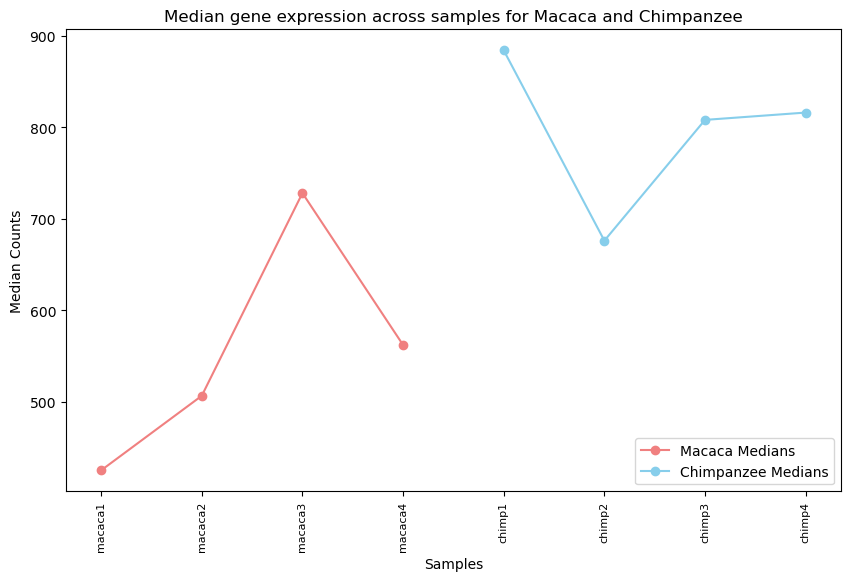

In [100]:
macaca_medians = df_counts[df_counts.columns[5:9]].median()
chimp_medians = df_counts[df_counts.columns[1:5]].median()

plt.figure(figsize=(10, 6))

plt.plot(macaca_medians.index, macaca_medians.values, marker='o', color='lightcoral', label='Macaca Medians')
plt.plot(chimp_medians.index, chimp_medians.values, marker='o', color='skyblue', label='Chimpanzee Medians')

plt.xticks(ticks=list(range(4, 8)) + list(range(0, 4)), labels=sample_columns, rotation=90, fontsize=8)
plt.xlabel("Samples")
plt.ylabel("Median Counts")
plt.title("Median gene expression across samples for Macaca and Chimpanzee")
plt.legend(loc="lower right")

plt.show()

In [102]:
sample_counts = [f'chimp{i}' for i in range(1, 5)] + [f'macaca{i}' for i in range(1, 5)]

In [103]:
df_counts = df_counts[['gene_symbol'] + sample_columns]
df_counts = df_counts.groupby('gene_symbol', as_index=False).max()
df_counts.iloc[:, 1:] = df_counts.iloc[:, 1:].astype(int)
df_counts.to_csv('data/counts_postprocessing_macaca.tsv', index=False, sep='\t')